In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import tree_util
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection as fdr

In [2]:
def nfr(d_df, profile, sname):
    sp_list = list(profile.columns)
    n = len(sp_list)
    corr = np.ones(shape=(n, n)) - d_df.loc[sp_list, sp_list].values
    np.fill_diagonal(corr, 0)
    # print(corr[1, 1])
    a = np.array(profile.loc[sname, sp_list])
    inter_matrix = np.dot(a.reshape(len(a), 1),a.reshape(1, len(a)))
    np.fill_diagonal(inter_matrix, 0)
    td = np.sum(inter_matrix)/2
    fr = np.sum(np.multiply(inter_matrix, corr))/2
    fd = np.sum(np.multiply(inter_matrix, d_df.loc[sp_list, sp_list].values))/2
    if td == 0:
        return 0
    return fr/td

def multisample_nfr(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    for sname in profile.index:
       for node, sp_list in node_leaves.items():
           sp_list = list(set(sp_list).intersection(set(profile.columns)))
           selected_d = d_df.loc[sp_list, sp_list]
           selected_profile = profile.loc[:, sp_list]
           value = nfr(selected_d, selected_profile, sname)
           result.loc[sname, node] = value
    return result


In [3]:
outdir = '../result/Anti_exposed/nFR'
if not os.path.exists(outdir):
    os.makedirs(outdir)
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
layer_leaves_dict = tree_util.make_layer_dict(nlayer)
tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
leaves_dict = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

node_leaves['root'] = list(leaf_list)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

In [4]:
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
metadata = pd.read_csv('../data/Anti/metadata.csv', sep=',', index_col=None, header=0)
abd = pd.read_csv('../data/Anti/abd.tsv', sep='\t', header=0, index_col=0)
special = ['P11', 'P12', 'P17', 'P18', 'P20', 'P22']


In [5]:
metadata = metadata[['Sample_Name', 'Timepoint', 'type']]
metadata = metadata.drop_duplicates(inplace=False)
abd_name_dict = {}
for idx in abd.index:
    abd_name_dict[idx] = idx.split('|')[-1].replace('_', '-')
abd = abd.rename(index=abd_name_dict)    

In [6]:
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
d_df = d_df.rename(columns=name_dict, index=name_dict)
abd = abd.T/100
sub_ids = sorted(list(set(metadata['Sample_Name'])))
days = sorted(list(set(metadata['Timepoint'])))
phenos = list(set(metadata['type']))
profile = abd[list(set(abd.columns).intersection(set(d_df.columns)))]
se_result = multisample_nfr(profile, d_df, node_leaves)
se_result.to_csv(os.path.join(outdir, 'nfr_df.tsv'), sep='\t')

In [7]:
p_cutoff = 0.05
if not os.path.exists(outdir):
    os.makedirs(outdir)

p1 = phenos[1]
p0 = phenos[0]
# compute p-value with fdr
p_df = pd.DataFrame(columns=days, index=list(node_leaves.keys()))
valid_dict = {}
for k in node_leaves.keys():
    metadata[k] = list(se_result.loc[list(metadata['Sample_Name']), k] )
    for j in days:
        selected0 = ['{}E{}'.format(x, j) for x in special]
        selected1 = list(set(metadata[(metadata['Timepoint'] == j) & (metadata['type'] == 'Exposed')]['Sample_Name']).difference(set(selected0)))
        selected_v0 = se_result.loc[selected0, k]
        selected_v1 = se_result.loc[selected1, k]
        if (list(selected_v0).count(0) > len(list(selected_v0))*0.8) and (list(selected_v1).count(0) > len(list(selected_v1))*0.8):
            continue
        if j not in valid_dict.keys():
            valid_dict[j] = []
        valid_dict[j].append(k)
        t, p = mannwhitneyu(list(selected_v0), list(selected_v1))
        p_df.loc[k, j] = p
        
p_df_adj = pd.DataFrame(columns=p_df.columns, index=list(node_leaves.keys()))
for d in days:
    p_values = p_df.loc[valid_dict[d], d]
    p_adj = fdr(p_values, p_cutoff)[1]
    for i, cluster in enumerate(valid_dict[d]):
        p_df_adj.loc[cluster, d] = p_adj[i]
p_df_adj.fillna(np.nan, inplace=True)
p_df_adj.to_csv(os.path.join(outdir, 'p_value.tsv'), sep='\t')



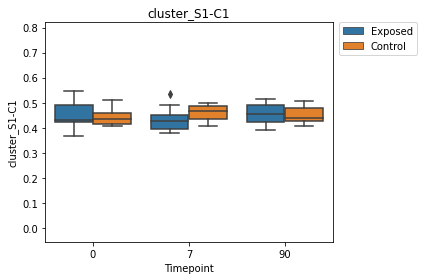

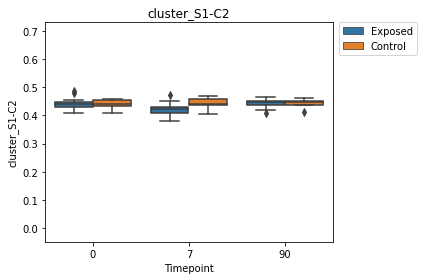

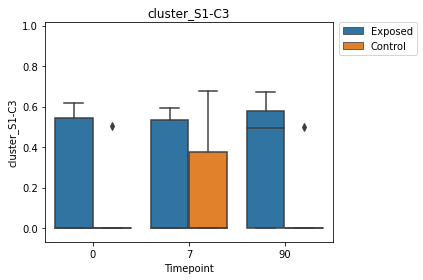

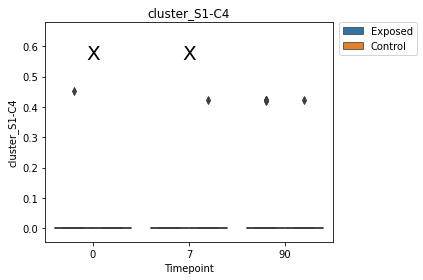

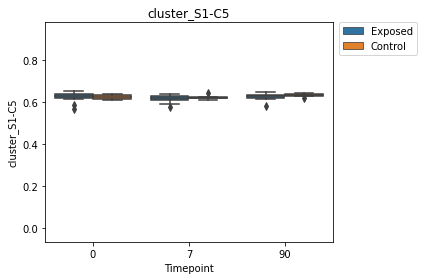

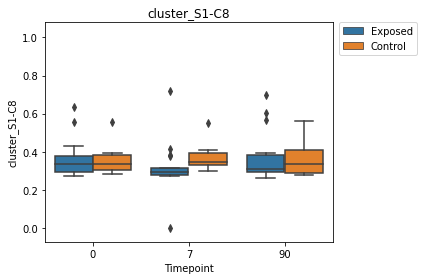

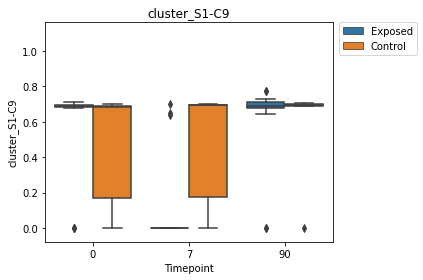

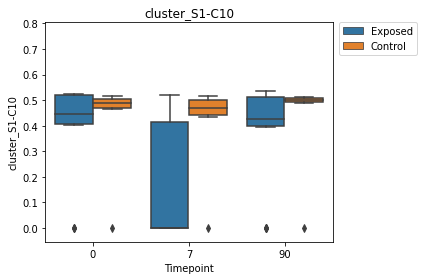

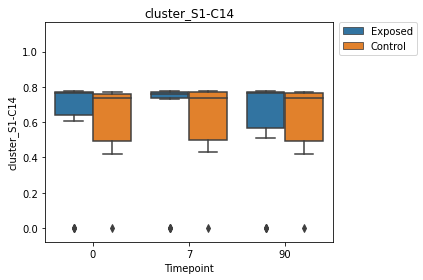

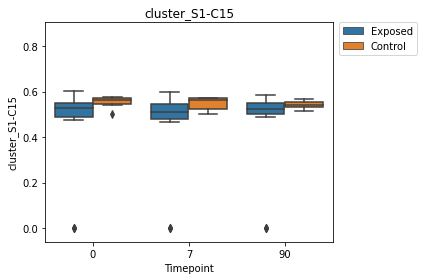

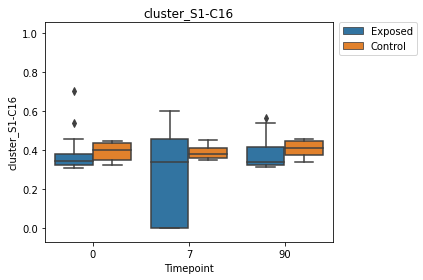

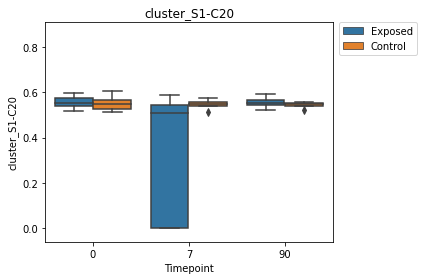

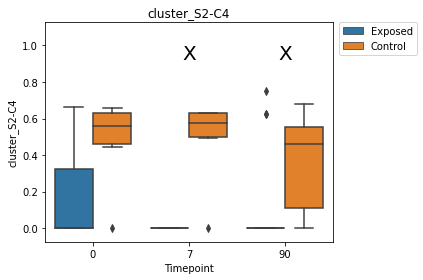

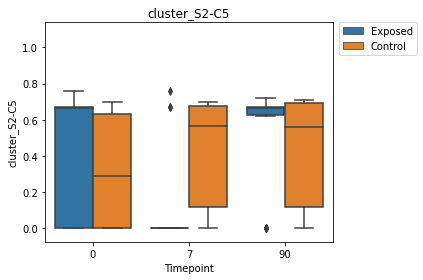

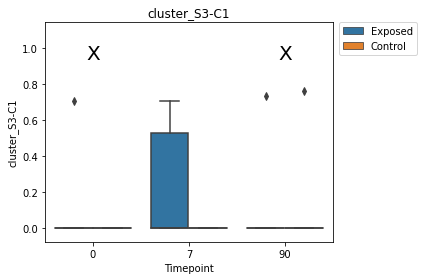

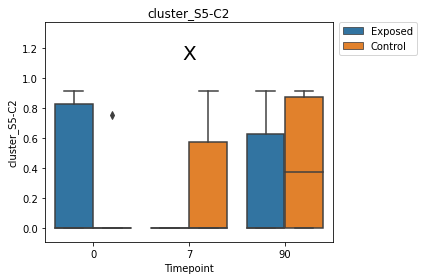

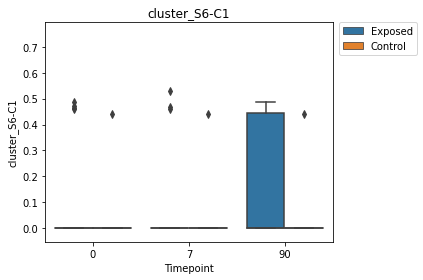

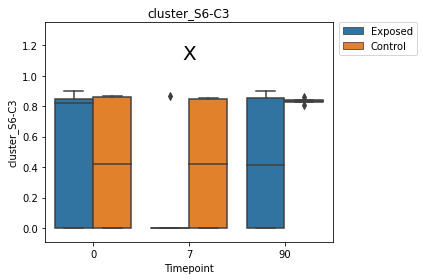

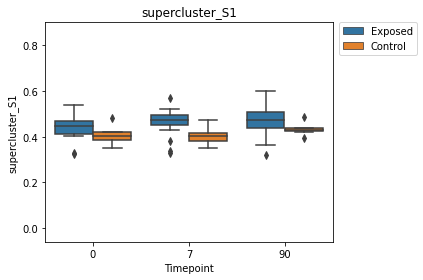

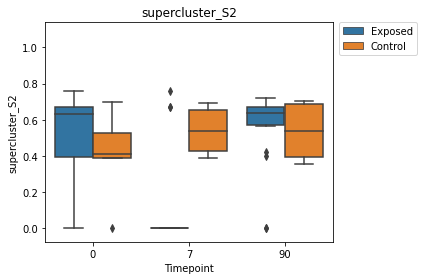

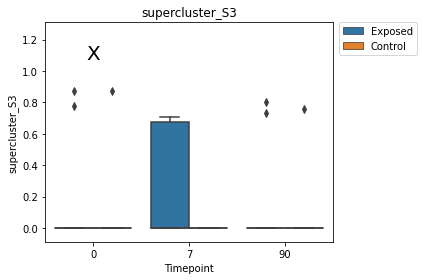

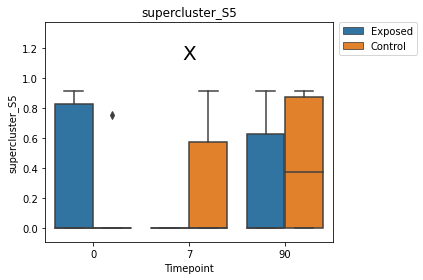

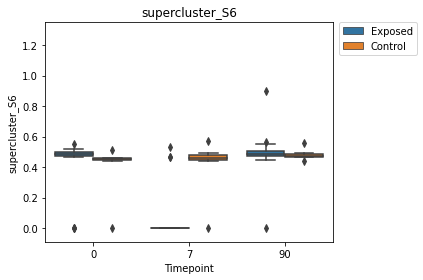

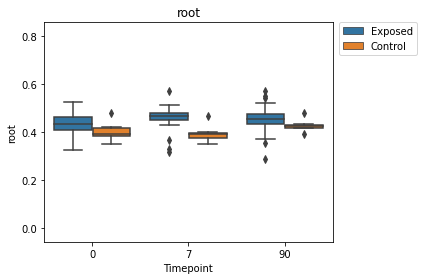

In [8]:
# draw
for k in node_leaves.keys():
    metadata[k] = list(se_result.loc[list(metadata['Sample_Name']), k] )
    max_v = max(list(metadata[k]))
    show = False
    for j in days:
        if k in valid_dict[j]:
            show = True
    if not show:
        continue
    sns.boxplot(x='Timepoint', y=k, hue='type', data=metadata)
    for i, t in enumerate(days):
        if pd.isna(p_df_adj.loc[k, t]):
            plt.text(i, max_v*1.2, 'X', ha='center', va='bottom', fontsize=20, color='black')

        if p_df_adj.loc[k, t] < p_cutoff:
            plt.text(i, max_v*1.2, '**', ha='center', va='bottom', fontsize=20, color='r')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.ylim(-0.1*max_v, max_v*1.5)
    plt.title(k)
    #plt.show()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, '{}.pdf'.format(k)), dpi=300, format='pdf')
    plt.show()
